In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_circles
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from itertools import combinations
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from xgboost import XGBClassifier



In [2]:
stroke = pd.read_csv("../00-data/healthcare-dataset-stroke-data.csv")

stroke


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
X = stroke.drop(['stroke', 'id'], axis=1)

y = stroke['stroke'].values

In [4]:
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

numerical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_with_imputation = ColumnTransformer(
  transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
  ])

pipeline_preprocessing = SKPipeline(steps=[
  ('preprocessor', preprocessor_with_imputation),
])


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [6]:
X_preprocessed = pipeline_preprocessing.fit_transform(X_train)

In [7]:
ratio = sum(y_train == 0) / sum(y_train == 1)

kpca_pipe = SKPipeline(
  steps=[
    ('kernelpca', KernelPCA(random_state=0)),
    ('xgboost', XGBClassifier(random_state=0, scale_pos_weight=ratio)) #, scale_pos_weight='ratio'
])

In [8]:
param_grid = [{
  'kernelpca__n_components': [3, 4, 5, 6], # 2, 3
  'kernelpca__kernel': ['linear', 'rbf'],
  'kernelpca__gamma': [0.1, 0.5, 1.0, 2.0],
  'xgboost__n_estimators': [100],
  'xgboost__learning_rate': [0.01, 0.1],
  'xgboost__max_depth': [3, 5]
},
# {
#   'kernelpca__n_components': [2, 3, 4, 5],
#   'kernelpca__kernel': ['linear'],
#   'xgboost__n_estimators': [100, 200],
#   'xgboost__learning_rate': [0.01, 0.1],
#   'xgboost__max_depth': [3, 5, 7]
# }
]

In [9]:
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)


In [10]:
gs = RandomizedSearchCV(kpca_pipe, param_distributions=param_grid, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, random_state=0, verbose=2, n_iter=20)
gs.fit(X_preprocessed, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('kernelpca',
                                              KernelPCA(random_state=0)),
                                             ('xgboost',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_m...
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions=[{'kernelpca__gamma': [0.1, 0.5, 1.0,
                                                              2.0],
                                         'kernelpca__kernel': ['linear', 'rbf'],
                                         'kernelpca__n_components': [3, 4, 5,
                                                                     6],
                                         'xgboost__learning_rate': [0.01, 0.1],
                                         'xgboost__max_depth': [3, 5],
                                         'xgboost__n_estimators': [100]}],
                   random_state=0, scoring='roc_auc', verbose=2)

In [11]:
gs.best_params_

{'xgboost__n_estimators': 100,
 'xgboost__max_depth': 3,
 'xgboost__learning_rate': 0.01,
 'kernelpca__n_components': 5,
 'kernelpca__kernel': 'linear',
 'kernelpca__gamma': 0.5}

In [12]:
gs.best_score_

np.float64(0.8144840695243842)

In [13]:
best_estimator = gs.best_estimator_

In [14]:
# visualmente non è possibile trovare dimensioni che distanzino le classi in modo chiaro

# for i in range(0, 5):
#     for j in range(i + 1, 6):
#         plt.figure(figsize=(10, 6))
#         plt.scatter(X_preprocessed[:, j], X_preprocessed[:, i], c=y_train, cmap='coolwarm', edgecolor='k', s=20)
#         plt.title(f'Kernel PCA Component {i+1} vs Component {j+1}')

In [15]:
def evaluate_predictions(predictions, y_true):
    cm = confusion_matrix(y_true, predictions)
    class_names = ['Classe 0 (Nessun ictus)', 'Classe 1 (Ictus)']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d')
    plt.show()
    
    perc_true_negative = cm[0,0]*100/(cm[0,0]+cm[0,1])
    perc_true_positive = cm[1,1]*100/(cm[1,0]+cm[1,1])
    
    print(f"Percentuale di veri negativi: {perc_true_negative:.2f}%")
    print(f"Percentuale di veri positivi: {perc_true_positive:.2f}%")
    
    print(classification_report(y_true, predictions, target_names=class_names))
    print(cm)
    
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    auc = roc_auc_score(y_true, predictions)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - SVM')
    plt.legend(loc='lower right')
    plt.show()

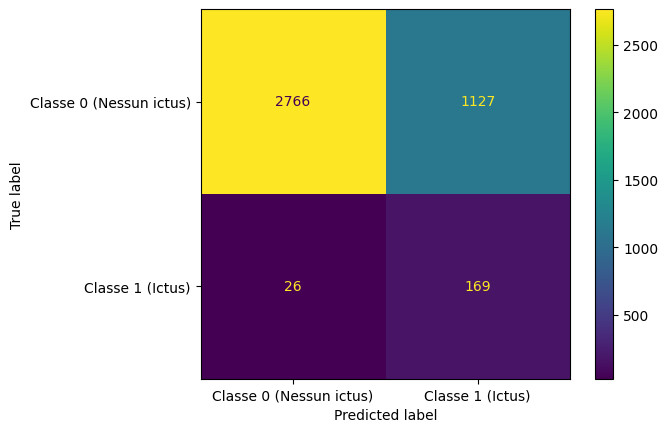

Percentuale di veri negativi: 71.05%
Percentuale di veri positivi: 86.67%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.99      0.71      0.83      3893
       Classe 1 (Ictus)       0.13      0.87      0.23       195

               accuracy                           0.72      4088
              macro avg       0.56      0.79      0.53      4088
           weighted avg       0.95      0.72      0.80      4088

[[2766 1127]
 [  26  169]]


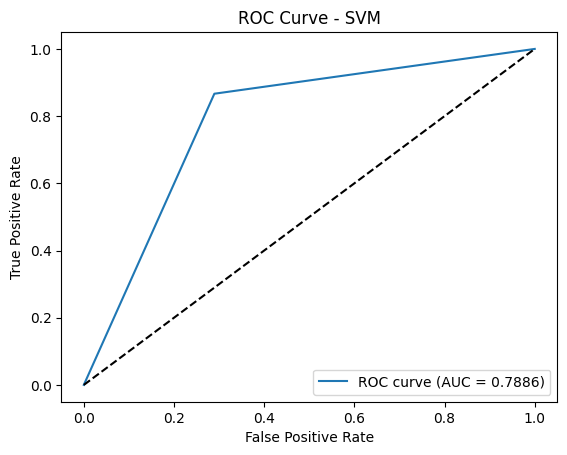

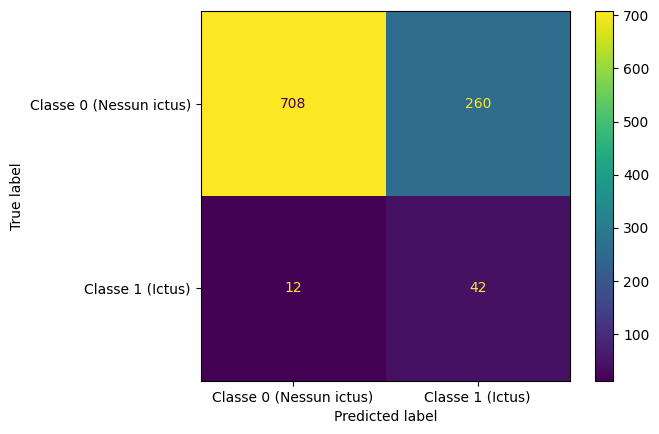

Percentuale di veri negativi: 73.14%
Percentuale di veri positivi: 77.78%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.98      0.73      0.84       968
       Classe 1 (Ictus)       0.14      0.78      0.24        54

               accuracy                           0.73      1022
              macro avg       0.56      0.75      0.54      1022
           weighted avg       0.94      0.73      0.81      1022

[[708 260]
 [ 12  42]]


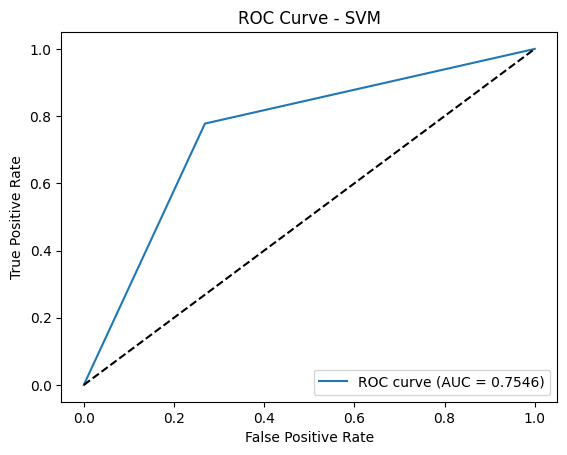

In [16]:
evaluate_predictions(best_estimator.predict(X_preprocessed), y_train)
X_test_preprocessed = pipeline_preprocessing.transform(X_test)
evaluate_predictions(best_estimator.predict(X_test_preprocessed), y_test)